In [2]:
import xgboost as xgb
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets
import pandas as pd
import seaborn as sns
%matplotlib inline

In [3]:
iris = datasets.load_iris()

# xgb.DMatrix
DMatrixには名前とデータを入れられれる  
その名前はboosterにも引き継がれるので設定しておくと後で便利

feature_namesは設定すると後でラクダが、feature_typesはplot_treeの見た目を変えるだけであまり変化はない（つけたければ、ぐらい）

In [6]:
features = ['SepalLength', 'SepalWidth', 'PetalLength', 'PetalWidth']

In [8]:
dm = xgb.DMatrix(iris.data,label=iris.target,feature_names=features,
                )

# Parameterの設定

boosterのパラメータを設定できる。

* eta[default=.3]
    * ステップサイズのshinkageパラメータ。小さいとたくさんshrinke
* gamma
    * 損失還元（loss reduction）
    * 木の葉を分割するときに必要とするパラメータ
    * 小さいと、簡単に分枝するのでよりフィットしやすくなる
* max_depth[default=6]
    * 木の深さの最大
* min_child_weight[default=1.]
    * 子ノードにおける最小重み（？
    * たぶんノードに含まれるデータの中にこの重みを超えるものがないと更新しないという意味か？
        * 大きい損失が含まれるノードが優先的に探索される
* max_delta_step[default=0]
    * よくわからない
    * 雰囲気、大きくすると一つの木の影響が小さくなる？
* subsample[default=1]
    * 一つの木を学習するのに使うサンプル数
    * あえて全てのデータを見ないことでオーバーフィットを防ぐ
* colsample_bytree[default=1]
    * 各木を作成するときのサブサンプルの割合
    
## タスク変数
* objective[default=reg:linear]
* base_score[default=.5]
* eval_metric[dafault=according to objective]
    * 二乗平均平方根誤差（RMSE)
    * 負の対数尤度(logloss)
    * 分類誤差（二値分類）。他クラスだとmerror
    * 他クラスの対数損失
    * AUC
    * mean average precision

In [13]:
params = {'objective':'multi:softprob',
         'eval_metric':'mlogloss',
         'eta': .3,
         'num_class':3}

In [14]:
np.random.seed(71)
bst = xgb.train(params,dm,num_boost_round=18)

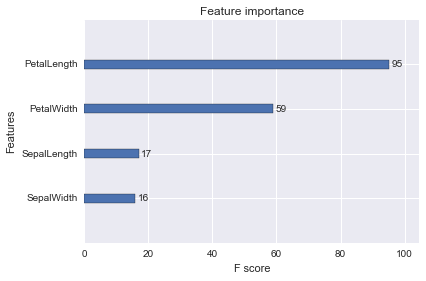

In [15]:
xgb.plot_importance(bst)

# CrossValidation
xgb.cvで行う

## 引数

* num_boost_round:
    * boostingを行う回数
    * 0~指定した回数　までのブースティング木をつくり、それぞれの結果を出力する
* nfold
    * データセットを分割する数
    * これで指定した数だけのsubsetが作成される

In [16]:
cv = xgb.cv(params,dm,num_boost_round=200,nfold=10)

In [37]:
cv.sort("test-mlogloss-mean",ascending=True).head()

,test-mlogloss-mean,test-mlogloss-std,train-mlogloss-mean,train-mlogloss-std
11,0.175506,0.177823,0.058496,0.004715
13,0.175514,0.194641,0.045222,0.004117
14,0.176150,0.203265,0.040493,0.004050
12,0.176277,0.186902,0.051074,0.004423
15,0.177926,0.208648,0.036855,0.003836


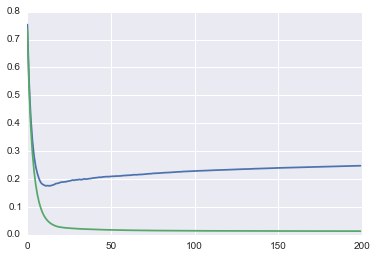

In [22]:
plt.plot(cv["test-mlogloss-mean"])
plt.plot(cv["train-mlogloss-mean"])

学習パラメータを変えてやってみる

In [25]:
params_custom = {'objective':'multi:softprob',
         'eval_metric':'mlogloss',
         'eta': .3,
         'num_class':3,
         'subsample':.5,
         'gamma':2.,
         'max_depth': 5}

In [27]:
cv2 = xgb.cv(params_custom,dm,num_boost_round=200,nfold=10)

In [36]:
cv2.sort("test-mlogloss-mean").head()

,test-mlogloss-mean,test-mlogloss-std,train-mlogloss-mean,train-mlogloss-std
87,0.170022,0.107676,0.127775,0.007256
140,0.170137,0.108713,0.124733,0.007648
141,0.170246,0.108959,0.124722,0.007600
139,0.170537,0.111437,0.124697,0.007720
142,0.170539,0.108347,0.124677,0.007600


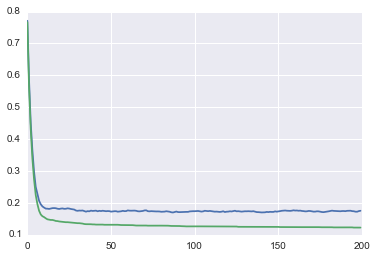

In [31]:
plt.plot(cv2["test-mlogloss-mean"])
plt.plot(cv2["train-mlogloss-mean"])

二つの比較

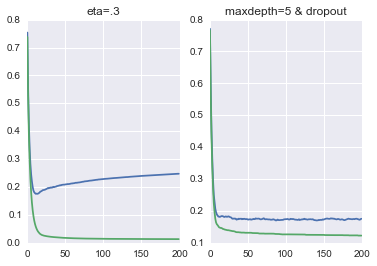

In [33]:
plt.subplot(1,2,1)
plt.plot(cv["test-mlogloss-mean"])
plt.plot(cv["train-mlogloss-mean"])
plt.title("eta=.3")
plt.subplot(1,2,2)
plt.plot(cv2["test-mlogloss-mean"])
plt.plot(cv2["train-mlogloss-mean"])
plt.title("maxdepth=5 & dropout")

In [40]:
cv2.sort("train-mlogloss-mean").index[0]

198